In [1]:
SAVED_MODEL_FILENAME = "saved_model"
FLOAT_TFL_MODEL_FILENAME = "float_model.tfl"
QUANTIZED_TFL_MODEL_FILENAME = "quantized_model.tfl"
TFL_CC_MODEL_FILENAME = "magic_wand_model_data.cc"

In [2]:
!curl -L https://github.com/Jisu0917/magic_wand_all/archive/5095a5906c29f08442e12118e231eb2ac0a354e3.zip -o magic_wand_data.zip
!unzip magic_wand_data.zip
!rm -rf magic_wand_data
!mv -f magic_wand_all-* magic_wand_data
!rm -rf magic_wand_data.zip
!rm -rf sample_data
!mkdir -p checkpoints

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  304k    0  304k    0     0   381k      0 --:--:-- --:--:-- --:--:--  381k
Archive:  magic_wand_data.zip
5095a5906c29f08442e12118e231eb2ac0a354e3
   creating: magic_wand_all-5095a5906c29f08442e12118e231eb2ac0a354e3/
  inflating: magic_wand_all-5095a5906c29f08442e12118e231eb2ac0a354e3/alphabet_a.json  
  inflating: magic_wand_all-5095a5906c29f08442e12118e231eb2ac0a354e3/alphabet_b.json  
  inflating: magic_wand_all-5095a5906c29f08442e12118e231eb2ac0a354e3/digit_0.json  
  inflating: magic_wand_all-5095a5906c29f08442e12118e231eb2ac0a354e3/digit_1.json  
  inflating: magic_wand_all-5095a5906c29f08442e12118e231eb2ac0a354e3/digit_2.json  
  inflating: magic_wand_all-5095a5906c29f08442e12118e231eb2ac0a354e3/digit_3.json  
  inflating: magic_wand_all-5095a

In [3]:
import glob
import json

strokes = []
for filename in glob.glob("magic_wand_data/*.json"):
  with open(filename, "r") as file:
    file_contents = file.read()
  file_data = json.loads(file_contents)
  for stroke in file_data["strokes"]:
    stroke["filename"] = filename
    strokes.append(stroke)

In [4]:
import matplotlib.pyplot as plt

def plot_stroke(stroke):

  x_array = []
  y_array = []
  for coords in stroke["strokePoints"]:
    x_array.append(coords["x"])
    y_array.append(coords["y"])

  fig = plt.figure(figsize=(12.8, 4.8))
  fig.suptitle(stroke["label"])

  ax = fig.add_subplot(131)
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_xlim(-0.4, 0.4)
  ax.set_ylim(-0.4, 0.4)
  ax.plot(x_array, y_array)

  plt.show()

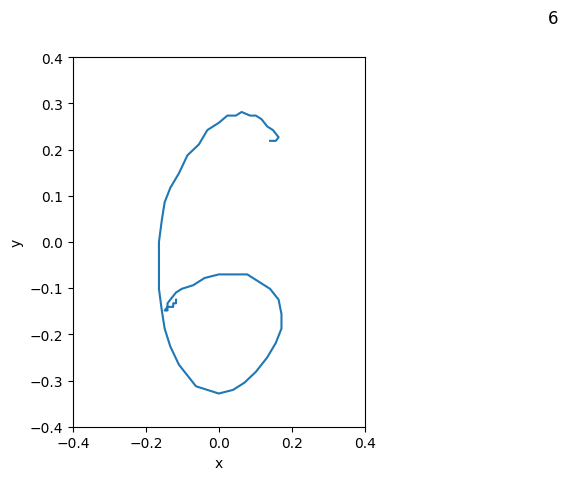

In [5]:
plot_stroke(strokes[11])

In [6]:
import math
import numpy as np
import PIL

FIXED_POINT = 256

def mul_fp(a, b):
  return (a * b) / FIXED_POINT

def div_fp(a, b):
  if b == 0:
    b = 1
  return (a * FIXED_POINT) / b

def float_to_fp(a):
  return math.floor(a * FIXED_POINT)

def norm_to_coord_fp(a, range_fp, half_size_fp):
  a_fp = float_to_fp(a)
  norm_fp = div_fp(a_fp, range_fp)
  return mul_fp(norm_fp, half_size_fp) + half_size_fp

def round_fp_to_int(a):
  return math.floor((a + (FIXED_POINT / 2)) / FIXED_POINT)

def gate(a, min, max):
  if a < min:
    return min
  elif a > max:
    return max
  else:
    return a

def rasterize_stroke(stroke_points, x_range, y_range, width, height):
  num_channels = 3
  buffer_byte_count = height * width * num_channels
  buffer = bytearray(buffer_byte_count)

  width_fp = width * FIXED_POINT
  height_fp = height * FIXED_POINT
  half_width_fp = width_fp / 2
  half_height_fp = height_fp / 2
  x_range_fp = float_to_fp(x_range)
  y_range_fp = float_to_fp(y_range)

  t_inc_fp = FIXED_POINT / len(stroke_points)

  one_half_fp = (FIXED_POINT / 2)

  for point_index in range(len(stroke_points) - 1):
    start_point = stroke_points[point_index]
    end_point = stroke_points[point_index + 1]
    start_x_fp = norm_to_coord_fp(start_point["x"], x_range_fp, half_width_fp)
    start_y_fp = norm_to_coord_fp(-start_point["y"], y_range_fp, half_height_fp)
    end_x_fp = norm_to_coord_fp(end_point["x"], x_range_fp, half_width_fp)
    end_y_fp = norm_to_coord_fp(-end_point["y"], y_range_fp, half_height_fp)
    delta_x_fp = end_x_fp - start_x_fp
    delta_y_fp = end_y_fp - start_y_fp

    t_fp = point_index * t_inc_fp
    if t_fp < one_half_fp:
      local_t_fp = div_fp(t_fp, one_half_fp)
      one_minus_t_fp = FIXED_POINT - local_t_fp
      red = round_fp_to_int(one_minus_t_fp * 255)
      green = round_fp_to_int(local_t_fp * 255)
      blue = 0
    else:
      local_t_fp = div_fp(t_fp - one_half_fp, one_half_fp)
      one_minus_t_fp = FIXED_POINT - local_t_fp
      red = 0
      green = round_fp_to_int(one_minus_t_fp * 255)
      blue = round_fp_to_int(local_t_fp * 255)
    red = gate(red, 0, 255)
    green = gate(green, 0, 255)
    blue = gate(blue, 0, 255)

    if abs(delta_x_fp) > abs(delta_y_fp):
      line_length = abs(round_fp_to_int(delta_x_fp))
      if delta_x_fp > 0:
        x_inc_fp = 1 * FIXED_POINT
        y_inc_fp = div_fp(delta_y_fp, delta_x_fp)
      else:
        x_inc_fp = -1 * FIXED_POINT
        y_inc_fp = -div_fp(delta_y_fp, delta_x_fp)
    else:
      line_length = abs(round_fp_to_int(delta_y_fp))
      if delta_y_fp > 0:
        y_inc_fp = 1 * FIXED_POINT
        x_inc_fp = div_fp(delta_x_fp, delta_y_fp)
      else:
        y_inc_fp = -1 * FIXED_POINT
        x_inc_fp = -div_fp(delta_x_fp, delta_y_fp)
    for i in range(line_length + 1):
      x_fp = start_x_fp + (i * x_inc_fp)
      y_fp = start_y_fp + (i * y_inc_fp)
      x = round_fp_to_int(x_fp)
      y = round_fp_to_int(y_fp)
      if (x < 0) or (x >= width) or (y < 0) or (y >= height):
        continue
      buffer_index = (y * width * num_channels) + (x * num_channels)
      buffer[buffer_index + 0] = red
      buffer[buffer_index + 1] = green
      buffer[buffer_index + 2] = blue

  np_buffer = np.frombuffer(buffer, dtype=np.uint8).reshape(height, width, num_channels)

  return np_buffer

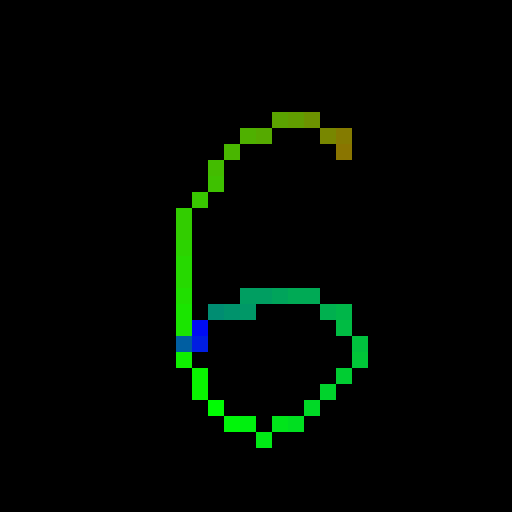

In [7]:
raster = rasterize_stroke(strokes[11]["strokePoints"], 0.5, 0.5, 32, 32)
PIL.Image.fromarray(raster).resize((512, 512), PIL.Image.NEAREST)

In [8]:
from pathlib import Path
import shutil

X_RANGE = 0.6
Y_RANGE = 0.6

def ensure_empty_dir(dirname):
  dirpath = Path(dirname)
  if dirpath.exists() and dirpath.is_dir():
    shutil.rmtree(dirpath)
  dirpath.mkdir()

def augment_points(points, move_range, scale_range, rotate_range):
  move_x = np.random.uniform(low=-move_range, high=move_range)
  move_y = np.random.uniform(low=-move_range, high=move_range)
  scale = np.random.uniform(low=1.0-scale_range, high=1.0+scale_range)
  rotate = np.random.uniform(low=-rotate_range, high=rotate_range)

  x_axis_x = math.cos(rotate) * scale
  x_axis_y = math.sin(rotate) * scale

  y_axis_x = -math.sin(rotate) * scale
  y_axis_y = math.cos(rotate) * scale

  new_points = []
  for point in points:
    old_x = point["x"]
    old_y = point["y"]
    new_x = (x_axis_x * old_x) + (x_axis_y * old_y) + move_x
    new_y = (y_axis_x * old_x) + (y_axis_y * old_y) + move_y
    new_points.append({"x": new_x, "y": new_y})

  return new_points

def save_strokes_as_images(strokes, root_folder, width, height, augment_count):
  ensure_empty_dir(root_folder)
  labels = set()
  for stroke in strokes:
    labels.add(stroke["label"].lower())
  for label in labels:
    label_path = Path(root_folder, label)
    ensure_empty_dir(label_path)

  label_counts = {}
  for stroke in strokes:
    points = stroke["strokePoints"]
    label = stroke["label"].lower()
    if label == "":
      raise Exception("Missing label for %s:%d" % (stroke["filename"], stroke["index"]))
    if label not in label_counts:
      label_counts[label] = 0
    label_count = label_counts[label]
    label_counts[label] += 1
    raster = rasterize_stroke(points, X_RANGE, Y_RANGE, width, height)
    image = PIL.Image.fromarray(raster)
    image.save(Path(root_folder, label, str(label_count) + ".png"))
    for i in range(augment_count):
      augmented_points = augment_points(points, 0.1, 0.1, 0.3)
      raster = rasterize_stroke(augmented_points, X_RANGE, Y_RANGE, width, height)
      image = PIL.Image.fromarray(raster)
      image.save(Path(root_folder, label, str(label_count) + "_a" + str(i) + ".png"))


In [9]:
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32

shuffled_strokes = strokes
np.random.shuffle(shuffled_strokes)

test_percentage = 10
validation_percentage = 10
train_percentage = 100 - (test_percentage + validation_percentage)

test_count = math.floor((len(shuffled_strokes) * test_percentage) / 100)
validation_count = math.floor((len(shuffled_strokes) * validation_percentage) / 100)
test_strokes = shuffled_strokes[0:test_count]
validation_strokes = shuffled_strokes[test_count:(test_count + validation_count)]
train_strokes = shuffled_strokes[(test_count + validation_count):]

save_strokes_as_images(test_strokes, "test", IMAGE_WIDTH, IMAGE_HEIGHT, 10)
save_strokes_as_images(validation_strokes, "validation", IMAGE_WIDTH, IMAGE_HEIGHT, 0)
save_strokes_as_images(train_strokes, "train", IMAGE_WIDTH, IMAGE_HEIGHT, 10)

In [10]:
import os
import tensorflow as tf
import numpy as np
from keras.preprocessing import image

# 이미지 크기
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32

# 데이터 경로
train_data_dir = 'train'
validation_data_dir = 'validation'

# 데이터셋 구성 함수
def create_dataset(data_dir):
    images = []
    flags = []
    labels = []

    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        if os.path.isdir(label_dir):
            flag = 1.0 if label.isdigit() else (2.0 if label in ['circle', 'heart', 'star'] else 3.0)
            for file in os.listdir(label_dir):
                if file.endswith(".png"):  # 이미지 파일만 고려
                    image_path = os.path.join(label_dir, file)
                    images.append(image_path)
                    flags.append(flag)
                    labels.append(label)  # 레이블 추가

    return images, flags, labels

# 훈련 데이터셋 생성
train_images, train_flags, train_labels = create_dataset(train_data_dir)

# 검증 데이터셋 생성
validation_images, validation_flags, validation_labels = create_dataset(validation_data_dir)

# 데이터셋 크기 확인
print("Train size:", len(train_images))
print("Validation size:", len(validation_images))

# 이미지 경로, 플래그, 레이블을 이용한 데이터셋 생성 함수
def preprocess_dataset(images, flags, labels):
    image_dataset = []
    for img_path, flag, label in zip(images, flags, labels):
        img = image.load_img(img_path, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
        img_array = image.img_to_array(img)
        img_array /= 255.0  # 이미지 정규화
        image_dataset.append((img_array, flag, label))  # 이미지, 플래그, 레이블 튜플 추가
    return image_dataset

# 데이터셋 구성
train_dataset = preprocess_dataset(train_images, train_flags, train_labels)
validation_dataset = preprocess_dataset(validation_images, validation_flags, validation_labels)

# 데이터셋 셔플
np.random.shuffle(train_dataset)
np.random.shuffle(validation_dataset)

# 데이터셋 변환 및 배치 설정
def prepare_dataset(dataset):
    images = np.array([item[0] for item in dataset])
    flags = np.array([item[1] for item in dataset])
    labels = np.array([item[2] for item in dataset])
    return images, flags, labels

train_images, train_flags, train_labels = prepare_dataset(train_dataset)
validation_images, validation_flags, validation_labels = prepare_dataset(validation_dataset)

Train size: 11143
Validation size: 126


In [11]:
import tensorflow as tf
from keras import layers, Model, Input
from keras.layers import Concatenate

# 모델 정의
def create_model():
    # 이미지 입력
    img_inputs = Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), name='img_inputs')
    # flag 입력
    flag_inputs = Input(shape=(1,), name='flag_inputs')

    # Entry block
    x = layers.Rescaling(1.0 / 255)(img_inputs)
    x = layers.Conv2D(16, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)

    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.5)(x)

    # Flag branch
    flag_branch = layers.Dense(64, activation='relu', name='output_flag')(flag_inputs)

    # Digit branch
    digit_x = layers.Dense(64, activation='relu')(x)
    digit_x = Concatenate()([digit_x, flag_branch])  # flag 정보를 레이어 출력에 추가
    digit_output = layers.Dense(10, activation='softmax', name='output_digit')(digit_x)

    # Figure branch
    figure_x = layers.Dense(64, activation='relu')(x)
    figure_x = Concatenate()([figure_x, flag_branch])  # flag 정보를 레이어 출력에 추가
    figure_output = layers.Dense(3, activation='softmax', name='output_figure')(figure_x)

    # Alphabet branch
    alphabet_x = layers.Dense(64, activation='relu')(x)
    alphabet_x = Concatenate()([alphabet_x, flag_branch])  # flag 정보를 레이어 출력에 추가
    alphabet_output = layers.Dense(2, activation='softmax', name='output_alphabet')(alphabet_x)   ####   26으로 바꿔주기   ####

    # Flag 값에 따라 해당하는 출력을 선택
    outputs = Concatenate(axis=-1)([digit_output, figure_output, alphabet_output])

    # 모델 정의
    model = Model(inputs=[img_inputs, flag_inputs], outputs=outputs)
    return model

# 모델 생성
model = create_model()


In [12]:
# 이미지 경로, 레이블, 플래그를 리스트로 저장
print(len(train_images))
print(len(train_flags))
print(len(train_labels))
print(len(validation_images))
print(len(validation_flags))
print(len(validation_labels))

11143
11143
11143
126
126
126


In [13]:
label_map = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
             'circle': 10, 'heart': 11, 'star': 12, 'a': 13, 'b': 14}

# train_labels 변환
train_labels_numeric = [label_map[label] for label in train_labels]

# validation_labels 변환
validation_labels_numeric = [label_map[label] for label in validation_labels]


In [14]:
epochs = 30
batch_size=32

# 모델 컴파일
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # from_logits=True 설정
    metrics=['accuracy']
)

# 콜백 정의
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("checkpoints/save_at_{epoch}.h5"),
]

# # 모델 훈련
# model.fit([train_images, train_flags], train_labels, epochs=30, batch_size=32,
#           validation_data=([validation_images, validation_flags], validation_labels))

# 모델 컴파일
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=["categorical_crossentropy", "categorical_crossentropy", "categorical_crossentropy"],
    metrics=["accuracy"]
)

# 모델 훈련
history = model.fit(
    [train_images, train_flags],
    tf.keras.utils.to_categorical(train_labels_numeric),
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(
        [validation_images, validation_flags],
        tf.keras.utils.to_categorical(validation_labels_numeric)
    ),
    callbacks=callbacks
)

Epoch 1/30
349/349 [==============================] - 11s 21ms/step - loss: 2.9754 - accuracy: 0.0445 - val_loss: 7.4322 - val_accuracy: 0.0635
Epoch 2/30
  4/349 [..............................] - ETA: 6s - loss: 2.8296 - accuracy: 0.0625

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


349/349 [==============================] - 8s 22ms/step - loss: 2.6929 - accuracy: 0.0566 - val_loss: 14.5685 - val_accuracy: 0.0635
Epoch 3/30
349/349 [==============================] - 6s 18ms/step - loss: 2.5749 - accuracy: 0.0533 - val_loss: 14.5685 - val_accuracy: 0.0635
Epoch 4/30
349/349 [==============================] - 8s 23ms/step - loss: 2.4392 - accuracy: 0.0589 - val_loss: 14.5685 - val_accuracy: 0.0635
Epoch 5/30
349/349 [==============================] - 6s 18ms/step - loss: 2.3440 - accuracy: 0.0642 - val_loss: 13.8533 - val_accuracy: 0.0635
Epoch 6/30
349/349 [==============================] - 8s 23ms/step - loss: 2.2754 - accuracy: 0.0743 - val_loss: 12.5118 - val_accuracy: 0.0238
Epoch 7/30
349/349 [==============================] - 6s 18ms/step - loss: 2.2317 - accuracy: 0.0753 - val_loss: 14.5685 - val_accuracy: 0.0635
Epoch 8/30
349/349 [==============================] - 8s 22ms/step - loss: 2.2052 - accuracy: 0.0815 - val_loss: 14.1366 - val_accuracy: 0.0635
Epo

In [16]:
import numpy as np
from keras.preprocessing import image

def predict_image(image_path, flag_value):
    # 이미지 로드 및 전처리
    img = image.load_img(image_path, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # 배치 차원 추가
    img_array /= 255.0  # Rescaling
    img_tensor = tf.cast(img_array, tf.uint8)  # uint8로 변환

    # Flag 값 설정
    flag_input = np.array([[flag_value]])  # 2차원 배열로 변환
    flag_tensor = tf.cast(flag_input, tf.uint8)

    # 이미지와 Flag 값을 결합
    combined_input = [img_tensor, flag_tensor]

    # 모델을 사용하여 예측 수행
    predictions = model.predict(combined_input)

    # 예측 결과 해석
    if flag_value == 1:
        digit_prediction = np.argmax(predictions[:, :10])
        digit_confidence = predictions[:, digit_prediction][0]  # 배열에서 첫 번째 값 추출
        return {
            "digit_prediction": digit_prediction,
            "digit_confidence": digit_confidence
        }
    elif flag_value == 2:
        figure_prediction = np.argmax(predictions[:, 10:13])
        figure_confidence = predictions[:, 10:13][0, figure_prediction]  # 배열에서 해당 클래스의 값 추출
        if figure_prediction == 0:
            figure_prediction = "circle"
        elif figure_prediction == 1:
            figure_prediction = "heart"
        elif figure_prediction == 2:
            figure_prediction = "star"
        return {
            "figure_prediction": figure_prediction,
            "figure_confidence": figure_confidence
        }
    elif flag_value == 3:
        alphabet_prediction = np.argmax(predictions[:, 13:])
        alphabet_confidence = predictions[:, 13:][0, alphabet_prediction]  # 배열에서 해당 클래스의 값 추출
        return {
            "alphabet_prediction": chr(97 + alphabet_prediction),  # 알파벳 예측값을 문자로 변환
            "alphabet_confidence": alphabet_confidence
        }

# 사용 예시
result_digit = predict_image("test/7/0.png", flag_value=1)
print("Digit prediction:", result_digit["digit_prediction"])
print("Digit confidence:", result_digit["digit_confidence"])

result_figure = predict_image("test/star/2.png", flag_value=2)
print("Figure prediction:", result_figure["figure_prediction"])
print("Figure confidence:", result_figure["figure_confidence"])

result_alphabet = predict_image("test/b/0.png", flag_value=3)
print("Alphabet prediction:", result_alphabet["alphabet_prediction"])
print("Alphabet confidence:", result_alphabet["alphabet_confidence"])


1/1 [==============================] - 0s 436ms/step
Digit prediction: 0
Digit confidence: 0.9993469
1/1 [==============================] - 0s 59ms/step
Figure prediction: heart
Figure confidence: 0.9814844
1/1 [==============================] - 0s 62ms/step
Alphabet prediction: a
Alphabet confidence: 1.0


In [17]:
result_digit = predict_image("test/7/0.png", flag_value=1)
print("Digit prediction:", result_digit["digit_prediction"])
print("Digit confidence:", result_digit["digit_confidence"])

result_figure = predict_image("test/star/2.png", flag_value=2)
print("Figure prediction:", result_figure["figure_prediction"])
print("Figure confidence:", result_figure["figure_confidence"])

result_alphabet = predict_image("test/b/0.png", flag_value=3)
print("Alphabet prediction:", result_alphabet["alphabet_prediction"])
print("Alphabet confidence:", result_alphabet["alphabet_confidence"])


1/1 [==============================] - 0s 123ms/step
Digit prediction: 0
Digit confidence: 0.9993469
1/1 [==============================] - 0s 120ms/step
Figure prediction: heart
Figure confidence: 0.9814844
1/1 [==============================] - 0s 111ms/step
Alphabet prediction: a
Alphabet confidence: 1.0


In [19]:
model.save(SAVED_MODEL_FILENAME)

In [20]:
import keras

# 대표 데이터셋 생성 함수
def representative_dataset():
    for filename in glob.glob("test/*/*.png"):
        img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # 배치 차원 추가
        img_array /= 255.0  # Rescaling
        img_tensor = tf.cast(img_array, tf.float32)  # float32로 변환
        # 이미지 파일 이름에서 flag 정보 추출
        flag_value = 1.0 if filename.split("/")[-2].isdigit() else (2.0 if filename.split("/")[-2] in ['circle', 'heart', 'star'] else 3.0)
        flag_input = np.array([[flag_value]], dtype=np.float32)  # 2차원 배열로 변환

        # 입력 및 출력 텐서 이름 지정
        inputs = {"img_inputs": img_tensor, "flag_inputs": flag_input}

        yield inputs


# TFLite 변환기 생성
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_FILENAME)

# 대표 데이터셋 설정
converter.representative_dataset = representative_dataset

# 최적화 설정
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# 입력 및 출력 데이터 타입 설정
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8  # 이미지 및 플래그 입력은 float32입니다.
converter.inference_output_type = tf.float32

# TFLite 모델 변환
model_tflite = converter.convert()

# 변환된 모델을 파일에 저장
open(QUANTIZED_TFL_MODEL_FILENAME, "wb").write(model_tflite)


51768